# Практическое занятие 14

## Вариант 11

In [32]:
class Config:
	"""
    Класс для хранения конфигурационных параметров системы массового обслуживания.
    - LAMBDA_RATE: Интенсивность поступления заявок (звонков в час)
	- MU_RATE: Интенсивность обслуживания одним каналом (звонков в час)
	- NUM_CHANNELS: Количество каналов (операторов) в системе
	- DURATION: Время T в часах, за которое рассчитываются характеристики системы
    """

	LAMBDA_RATE = 60
	MU_RATE = 15
	NUM_CHANNELS = 5
	DURATION = 4


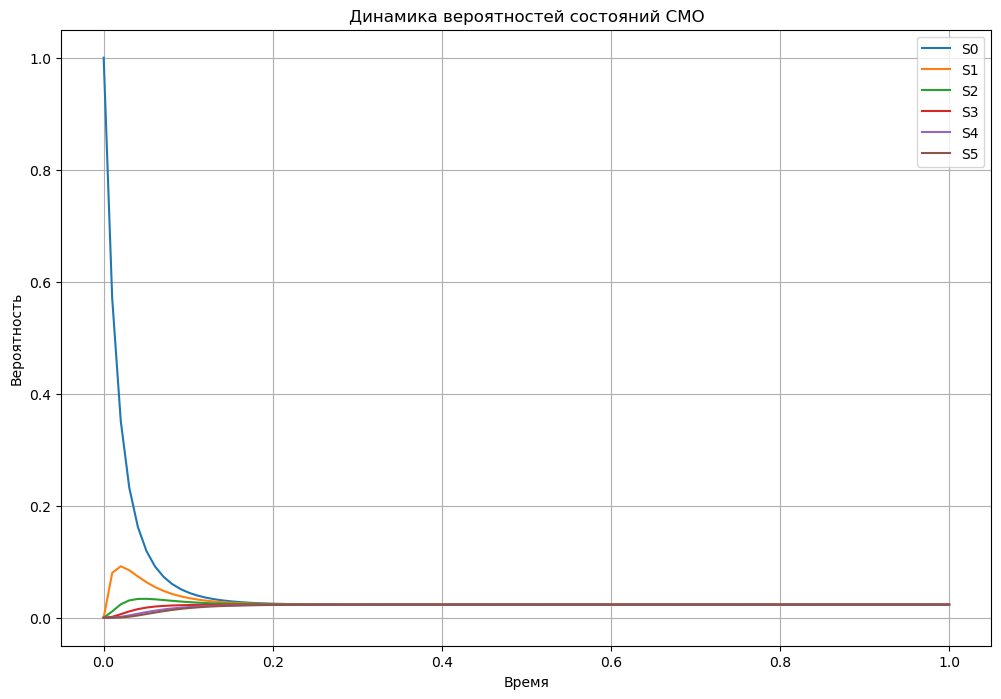

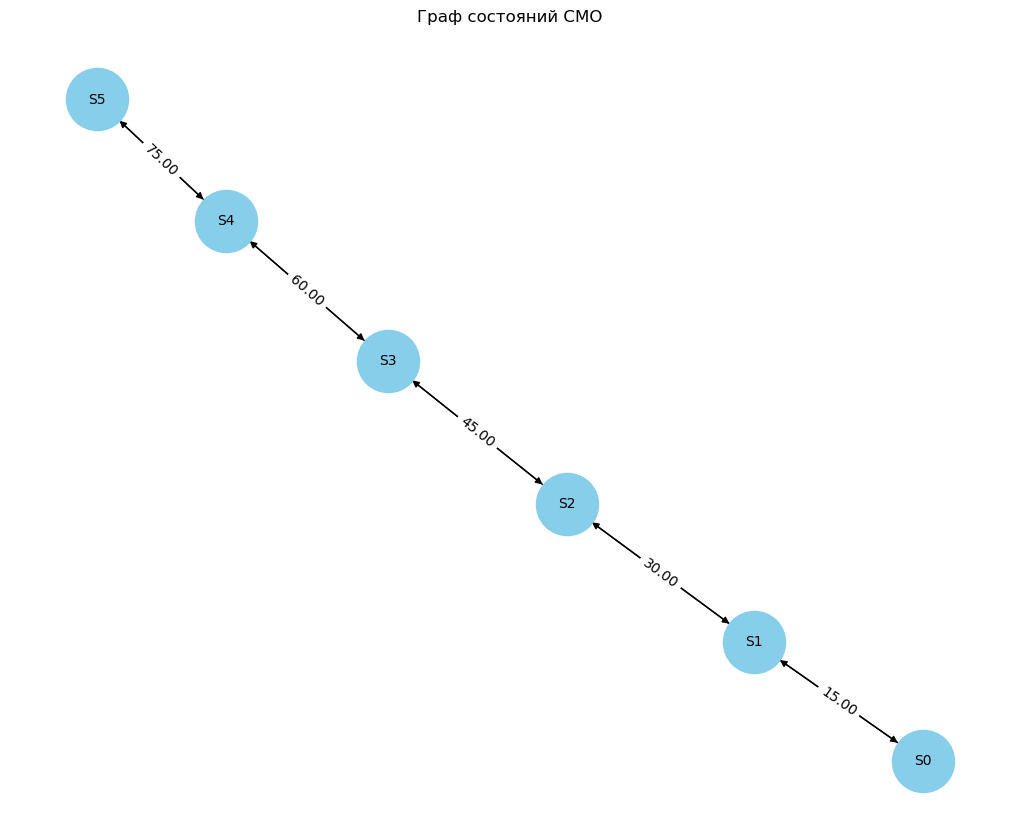

In [36]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import networkx as nx

class State:
	"""
	Класс, представляющий состояние в марковской модели.
	"""
	def __init__(self, name):
		"""
        Инициализирует новое состояние с заданным именем.

        :param name: Название состояния.
        """
		self.name = name


class Transition:
	"""
	Класс, представляющий переход между состояниями в марковской модели.
	"""
	def __init__(self, from_state, to_state, rate):
		"""
        Инициализирует новый переход между состояниями с заданной интенсивностью.

        :param from_state: Состояние, из которого происходит переход.
        :param to_state: Состояние, в которое происходит переход.
        :param rate: Интенсивность перехода.
        """
		self.from_state = from_state
		self.to_state = to_state
		self.rate = rate

class ServiceSystem:
	"""
	Класс для моделирования и анализа марковской системы массового обслуживания.
	"""
	def __init__(self, lambda_rate, mu_rate, num_channels):
		"""
       	Инициализирует систему с заданными параметрами.

	    :param lambda_rate: Интенсивность поступления заявок.
	    :param mu_rate: Интенсивность обслуживания одним каналом.
	    :param num_channels: Количество каналов обслуживания.
	    """
		self.lambda_rate = lambda_rate
		self.mu_rate = mu_rate
		self.num_channels = num_channels
		self.states = [State(f"S{i}") for i in range(num_channels + 1)]
		self.transitions = self._create_transitions()

	def _create_transitions(self):
		"""
        Создает переходы между состояниями системы на основе интенсивностей поступления и обслуживания.
        """
		transitions = []
		for i in range(self.num_channels + 1):
			if i > 0:
				transitions.append(Transition(self.states[i], self.states[i-1], i * self.mu_rate))
			if i < self.num_channels:
				transitions.append(Transition(self.states[i], self.states[i+1], self.lambda_rate))
		return transitions

	def solve_kolmogorov(self, t_span, initial_conditions, t_eval):
		"""
		Решает систему уравнений Колмогорова для определения динамики вероятностей состояний системы.

        :param t_span: Интервал времени для решения системы.
        :param initial_conditions: Начальные условия для вероятностей состояний.
        :param t_eval: Точки времени для вычисления решения.
        :return: Объект результата решения, содержащий временные точки и вероятности состояний.
		"""
		def kolmogorov_equations(t, p):
			"""
			Определяет систему дифференциальных уравнений для вероятностей состояний.

            :param t: Текущее время.
            :param p: Вероятности состояний в текущий момент.
            :return: Производные вероятностей по времени.
			"""
			dpdt = np.zeros_like(p)
			for i, state in enumerate(self.states):
				if i > 0:
					dpdt[i] += i * self.mu_rate * p[i-1]
				if i < self.num_channels:
					dpdt[i] -= self.lambda_rate * p[i]
				if i > 0:
					dpdt[i] -= i * self.mu_rate * p[i]
				if i < self.num_channels:
					dpdt[i] += self.lambda_rate * p[i+1]
			return dpdt

		solution = solve_ivp(kolmogorov_equations, t_span, initial_conditions, t_eval=t_eval)
		return solution

	def plot_state_graph(self):
		"""
		Визуализирует граф состояний системы, показывая возможные переходы и их интенсивности.
        """
		G = nx.DiGraph()
		for transition in self.transitions:
			G.add_edge(transition.from_state.name, transition.to_state.name, label=f"{transition.rate:.2f}")

		pos = nx.spring_layout(G)
		plt.figure(figsize=(10, 8))
		nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10)
		edge_labels = nx.get_edge_attributes(G, 'label')
		nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
		plt.title("Граф состояний СМО")
		plt.show()


system = ServiceSystem(Config.LAMBDA_RATE, Config.MU_RATE, Config.NUM_CHANNELS)

# Решение системы уравнений Колмогорова
t_span = (0, 1)  # интервал времени
initial_conditions = [1] + [0] * Config.NUM_CHANNELS  # начальные условия
t_eval = np.linspace(t_span[0], t_span[1], 100)  # временные точки для решения
solution = system.solve_kolmogorov(t_span, initial_conditions, t_eval)

# Визуализация решения системы уравнений
plt.figure(figsize=(12, 8))
for i, state in enumerate(system.states):
	plt.plot(solution.t, solution.y[i], label=state.name)
plt.title("Динамика вероятностей состояний СМО")
plt.xlabel("Время")
plt.ylabel("Вероятность")
plt.legend()
plt.grid(True)
plt.show()

# Визуализация графа состояний
system.plot_state_graph()


In [37]:
class SMOCharacteristics:
	"""
	Класс для расчета основных характеристик системы массового обслуживания.
	"""
	def __init__(self, lambda_rate, mu_rate, num_channels, duration):
		"""
        Инициализация параметров системы массового обслуживания.

        :param lambda_rate: Интенсивность поступления заявок (звонков в час).
        :param mu_rate: Интенсивность обслуживания одним каналом (звонков в час).
        :param num_channels: Количество каналов (операторов) в системе.
        :param duration: Время T в часах, за которое рассчитываются характеристики системы.
        """
		self.lambda_rate = lambda_rate
		self.mu_rate = mu_rate
		self.num_channels = num_channels
		self.duration = duration  # Время T в часах
		self.ksi = self.calculate_ksi()
		self.P0 = self.calculate_probability_of_downtime()
		self.P = self.calculate_probabilities()

	def calculate_ksi(self):
		"""
		Рассчитывает интенсивность нагрузки на СМО (ksi = lambda_rate / mu_rate).

		:return: Интенсивность нагрузки на систему.
		"""
		return self.lambda_rate / self.mu_rate

	def calculate_probability_of_downtime(self):
		"""
		Вычисляет вероятность простоя системы (P0).

        :return: Вероятность того, что все каналы свободны.
		"""
		return 1 / sum((self.ksi ** i) / np.math.factorial(i) for i in range(self.num_channels))


	def calculate_probabilities(self):
		"""
		Создает словарь вероятностей того, что ровно i каналов заняты.

        :return: Словарь вероятностей для каждого состояния от P1 до Pn.
		"""
		probabilities = {f"P{i}": (self.ksi**i) / np.math.factorial(i) * self.P0 for i in range(1, self.num_channels + 1)}
		return probabilities

	def probability_of_rejection(self):
		"""
		Вычисляет вероятность отказа в системе (все каналы заняты).

        :return: Вероятность отказа новой заявки.
		"""
		return self.P[f"P{self.num_channels}"]

	def average_incoming_requests_during_T(self):
		"""
		Рассчитывает среднее число заявок, поступающих в систему за время T.

        :return: Среднее количество заявок за время T.
		"""
		return self.lambda_rate * self.duration

	def average_service_time_per_request(self):
		"""
		Вычисляет среднее время обслуживания одной заявки.

        :return: Среднее время обслуживания одной заявки.
		"""
		return 1 / self.mu_rate

	def average_service_time_per_channel_for_T(self):
		"""
		Вычисляет среднее время обслуживания одним каналом заявок, поступивших за время T.

        :return: Среднее время обслуживания заявок за время T одним каналом.
        """
		return self.ksi * self.duration

	def average_number_of_busy_channels(self):
		"""
		Вычисляет среднее число занятых каналов в системе.

        :return: Среднее количество занятых каналов.
		"""
		probabilities = self.calculate_probabilities()
		average_busy = sum(i * probabilities[f"P{i}"] for i in range(1, self.num_channels + 1))
		return average_busy

# Использование класса
smo = SMOCharacteristics(
	lambda_rate=60,
	mu_rate=15,
	num_channels=5,
	duration=4)

# Получение характеристик
print(f'кси: {smo.ksi}')
print(f'Вероятность простоя: {smo.calculate_probability_of_downtime()}')
print(f'Вероятности того, что i каналов заняты : {smo.calculate_probabilities()}')
print(f'Вероятность отказа: {smo.probability_of_rejection()}')
print(f'Среднее число заявок в системе за время T: {smo.average_incoming_requests_during_T()} в час')
print(f'Среднее время обслуживания 1 заявки: {smo.average_service_time_per_request()}')
print(f'Среднее время обслуживания одним каналом заявок, поступивших за время T: {smo.average_service_time_per_channel_for_T()}')
print(f'Среднее число занятых каналов: {smo.average_number_of_busy_channels()}')

кси: 4.0
Вероятность простоя: 0.029126213592233014
Вероятности того, что i каналов заняты : {'P1': 0.11650485436893206, 'P2': 0.2330097087378641, 'P3': 0.31067961165048547, 'P4': 0.31067961165048547, 'P5': 0.2485436893203884}
Вероятность отказа: 0.2485436893203884
Среднее число заявок в системе за время T: 240 в час
Среднее время обслуживания 1 заявки: 0.06666666666666667
Среднее время обслуживания одним каналом заявок, поступивших за время T: 16.0
Среднее число занятых каналов: 4.000000000000001
